In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import partial_corr
import corr_significance

Lab 2:
Ниже представлено то, что уже сделано.
Что ещё нужно сделать:
- порисовать гистограммы, в т.ч. для признака $State$
- сформулировать задачу регрессии после отбора, анализа и преобразования признаков
- оценить качество регрессии (множественный коэффициент корреляции, распределение остатков, мультиколлинеарность.

Также из Lab 1 нужны результаты о распределениях некоторых из признаков (и по возможности идеи, как их преобразовать, чтобы было что-то похожее хотя бы на нормальное распределение)

In [2]:
#roads = pd.read_csv('fulldata.csv')
#roads.head()

Взгляд на данные

In [3]:
#roads.describe()

Здесь отбираем выборку в 1000 наблюдений по признакам, перечисленным в ячейке.
- Вопрос: возможно, здесь стоит отобрать выборку стратифицированно по $State$
- Выбор признаков не окончательный: всё зависит от результатов проверок гипотез, но предсказывать будем Friction как меру риска ДТП

In [4]:
#np.random.seed(42)
#sample = roads.sample(1000)

In [5]:
sample = pd.read_csv("sample.csv")

In [6]:
sample1 = sample[['State_', 'Ta_mean', 'Tsurf_mean', 'Water_mean', 'Speed_mean', 'Height_mean', 'Friction_mean', 'mintempC', 'DewPointC', 'humidity', 'pressure']]

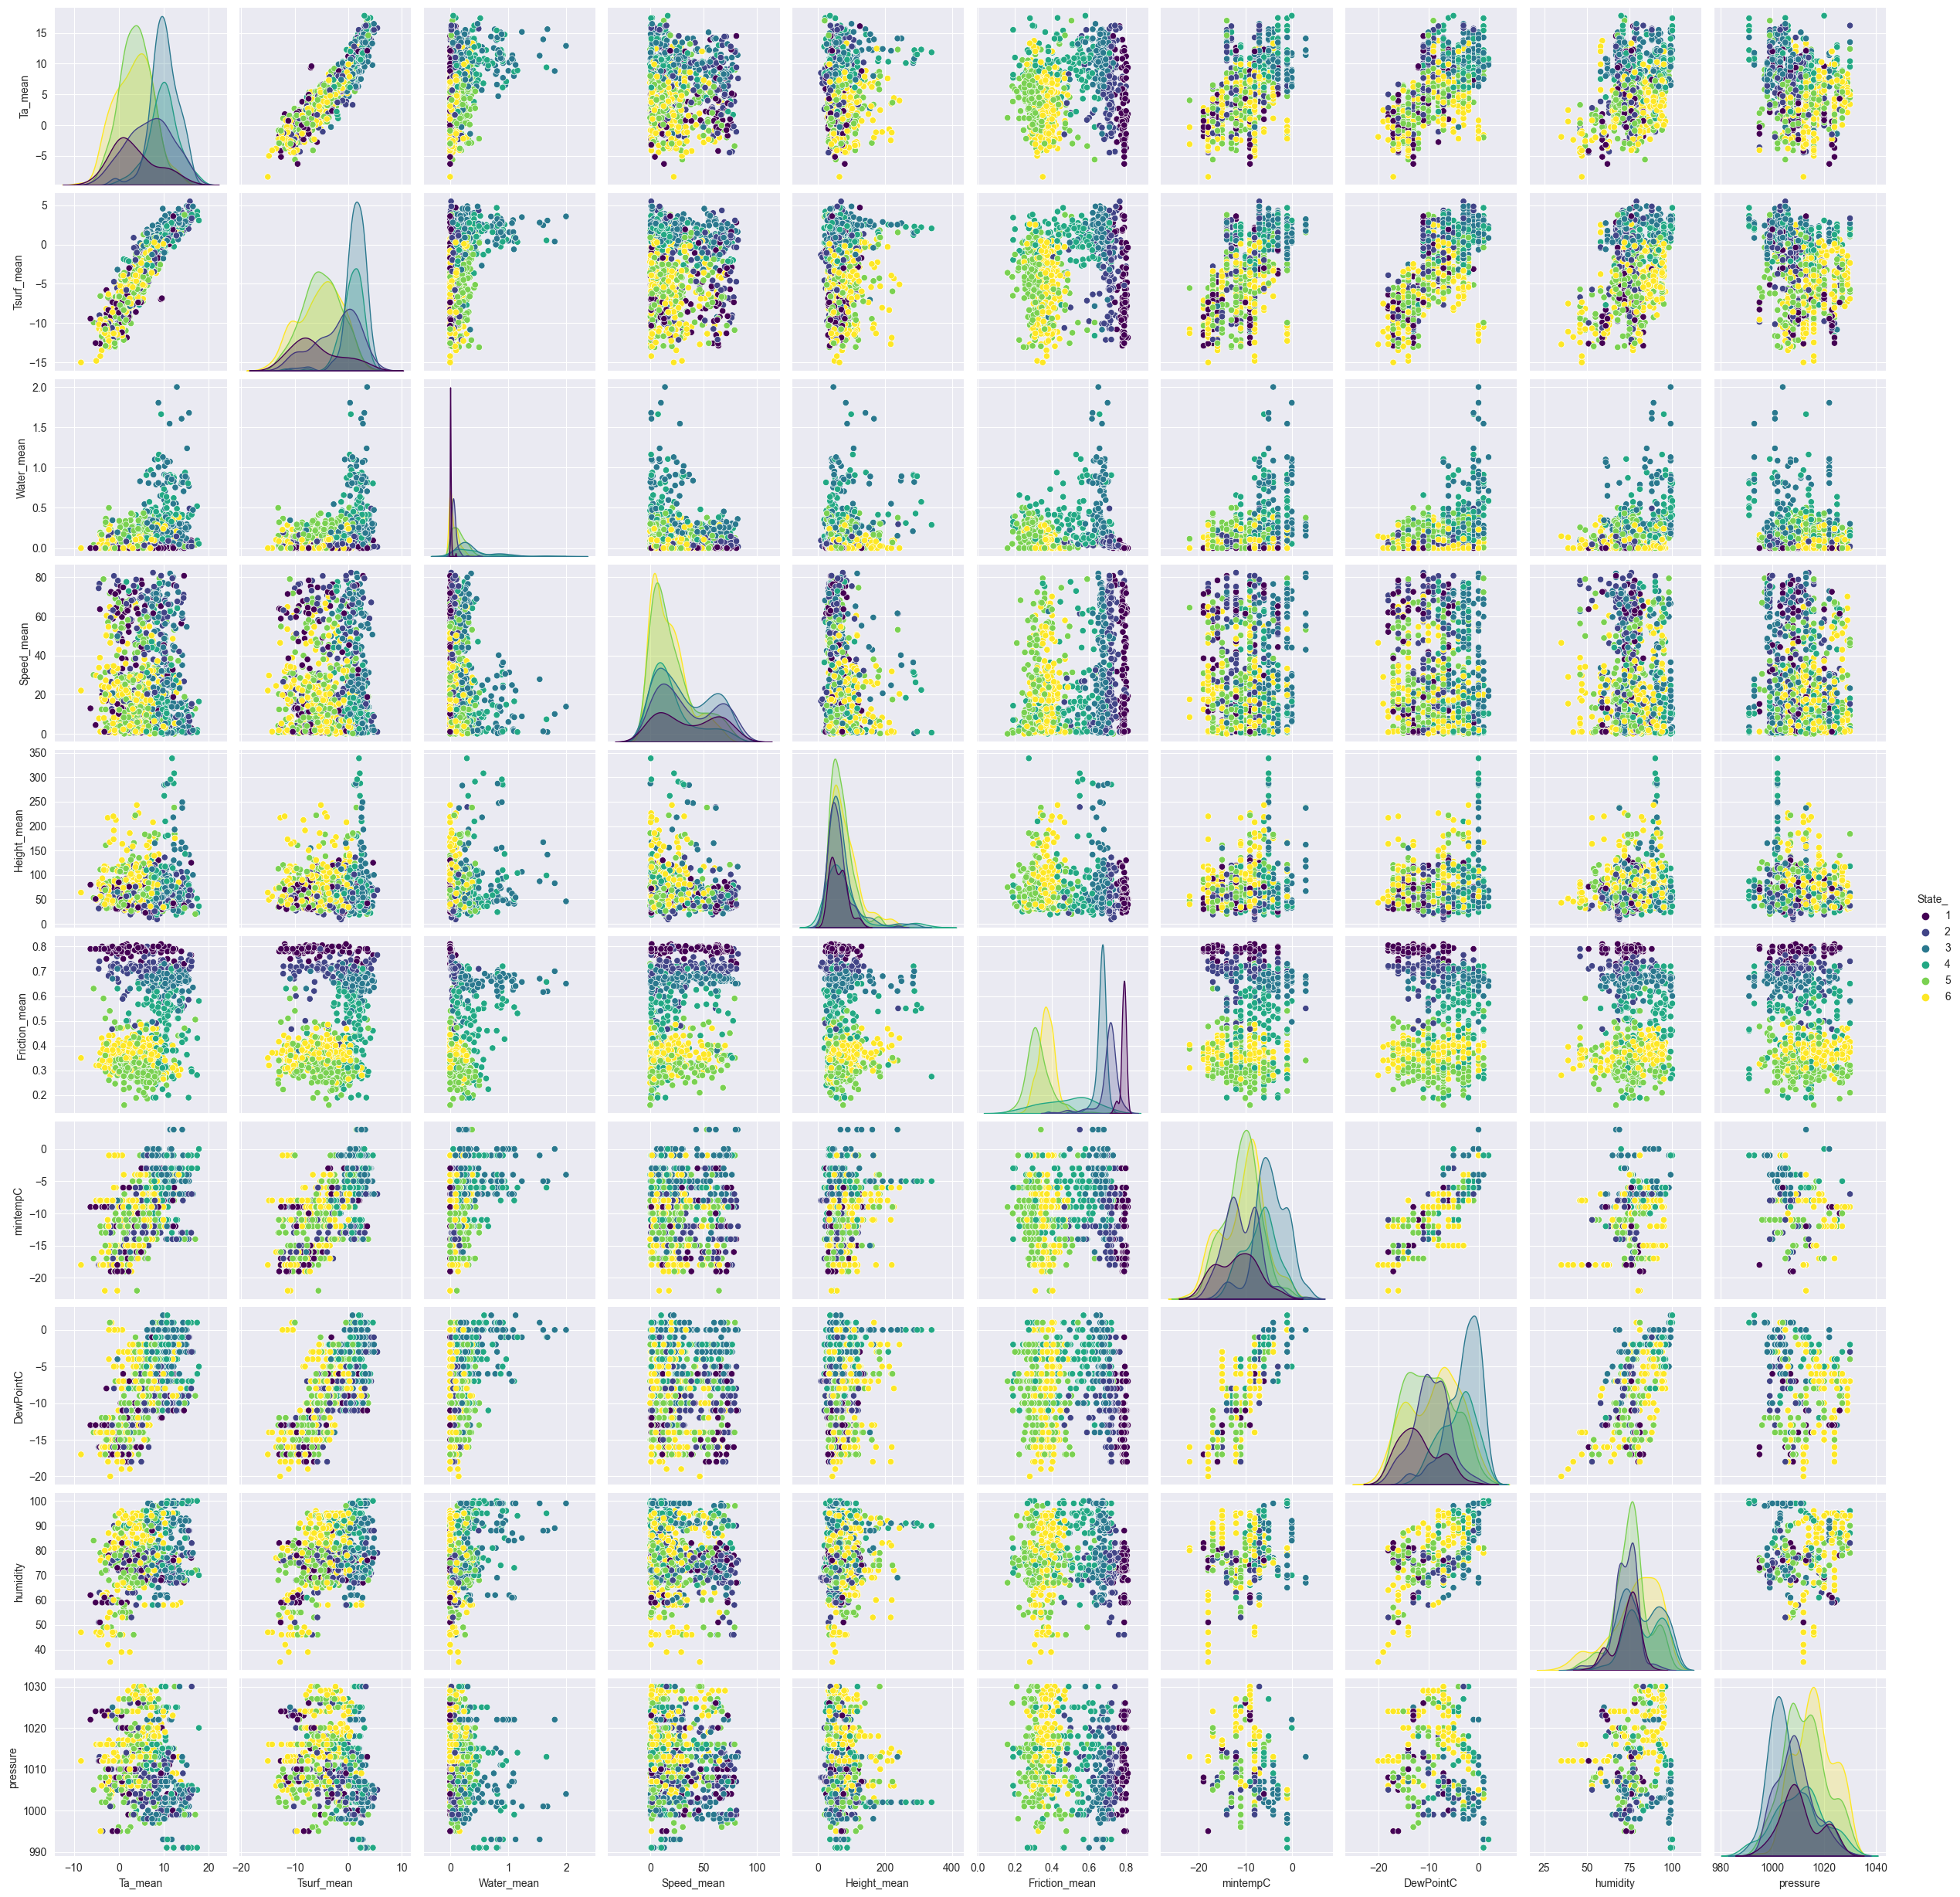

In [7]:
sns.pairplot(data = sample1, hue='State_', palette='viridis')

Методом пристального взгляда в признаке Friction можно разглядеть мультимодальность, разбиваемую по State: State < 3, State = 4, State > 4

Предсказывать будем $Friction$ (как показатель риска аварий) по (всем признакам, потом расширю описание признаков)
- $Tsurf$ - температура поверхности
- $Water$ - толщина водяного слоя
- $Speed$ - скорость ветра
- $Height$ - высота над уровнем моря
- $mintempC$ - минимальная температура в регионе (нужно уточить)
- $DewPointC$ - точка росы
- $humidity$ - влажность
- $pressure$ - атмосферное давление
- $State$ - словесное описание состояния поверхности дороги

После рассмотрения PairPlot'a можно увидеть, что Friction довольно бимодальна и это объяснимо показателем State: можно разбить данные по $State > 4$ и $State \le 4$

Здесь мы просто смотрим векторы средних и ковариационные матрицы после разбиения.

In [8]:
sample = sample[['State_', 'Friction_mean', 'Ta_mean', 'Tsurf_mean',
       'Water_mean', 'Speed_mean', 'Height_mean',
       'Direction_min', 'Direction_max', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']]

In [9]:
samplel4, sample4, sampleb4 = sample[sample['State_'] < 4], sample[sample['State_'] == 4], sample[sample['State_'] > 4]

In [10]:
samplel4.mean()

State_              2.232446
Friction_mean       0.702652
Ta_mean             7.521634
Tsurf_mean         -1.397904
Water_mean          0.210166
Speed_mean         33.798909
Height_mean        64.505240
Direction_min     138.938257
Direction_max     204.491041
maxtempC           -2.789346
mintempC           -8.312349
totalSnow_cm        1.668523
sunHour             0.955206
uvIndex             1.501211
DewPointC          -7.169492
FeelsLikeC         -8.268765
HeatIndexC         -3.549637
WindChillC         -8.268765
WindGustKmph       21.963680
cloudcover         60.382567
humidity           76.496368
precipMM            0.144794
pressure         1008.067797
tempC              -3.569007
visibility          8.777240
winddirDegree     144.600484
windspeedKmph      13.368039
dtype: float64

In [11]:
sample4.mean()

State_              4.000000
Friction_mean       0.482216
Ta_mean             9.825337
Tsurf_mean          0.688048
Water_mean          0.350411
Speed_mean         20.516655
Height_mean        77.548697
Direction_min     147.271667
Direction_max     216.575833
maxtempC           -0.883333
mintempC           -6.925000
totalSnow_cm        4.387500
sunHour             1.074167
uvIndex             1.291667
DewPointC          -4.275000
FeelsLikeC         -5.625000
HeatIndexC         -1.833333
WindChillC         -5.625000
WindGustKmph       18.333333
cloudcover         68.475000
humidity           83.775000
precipMM            0.371667
pressure         1010.641667
tempC              -1.866667
visibility          7.175000
winddirDegree     179.841667
windspeedKmph      11.533333
dtype: float64

In [12]:
sampleb4.mean()

State_              5.496788
Friction_mean       0.348648
Ta_mean             3.627040
Tsurf_mean         -5.102501
Water_mean          0.107762
Speed_mean         19.256158
Height_mean        75.472420
Direction_min     122.360814
Direction_max     230.014775
maxtempC           -4.460385
mintempC          -10.584582
totalSnow_cm        3.231263
sunHour             2.356745
uvIndex             1.486081
DewPointC          -9.207709
FeelsLikeC        -10.229122
HeatIndexC         -5.665953
WindChillC        -10.229122
WindGustKmph       19.691649
cloudcover         56.147752
humidity           76.884368
precipMM            0.101927
pressure         1014.366167
tempC              -5.704497
visibility          8.147752
winddirDegree     142.265525
windspeedKmph      11.805139
dtype: float64

In [13]:
samplel4.cov()

State_  Friction_mean    Ta_mean  Tsurf_mean  Water_mean  \
State_          0.596323      -0.034264   1.976987    2.138394    0.134911   
Friction_mean  -0.034264       0.003870  -0.108789   -0.112036   -0.007496   
Ta_mean         1.976987      -0.108789  24.201044   20.158774    0.549371   
Tsurf_mean      2.138394      -0.112036  20.158774   20.105644    0.542527   
Water_mean      0.134911      -0.007496   0.549371    0.542527    0.090132   
Speed_mean     -1.038841       0.221632 -16.836582   -9.846824   -1.783341   
Height_mean     3.937190      -0.212637  27.535080   20.874188    2.868386   
Direction_min  -0.040225      -0.197811  -5.176961  -13.849728    0.011282   
Direction_max   1.854029      -0.213605  -7.075537    5.257801    0.231122   
maxtempC        2.426644      -0.127278  14.117321   15.400633    0.690475   
mintempC        2.356761      -0.121288  10.955119   12.691385    0.720698   
totalSnow_cm    1.183791      -0.054583   3.849273    5.370318    0.444917   
sunHour        -0.091747       0.006164  -3.169488   -2.852829    0.024735   
uvIndex        -0.150768       0.006456  -0.762710   -0.743652   -0.050905   
DewPointC       2.813765      -0.142633  16.904634   17.972853    0.891042   
FeelsLikeC      3.125732      -0.168053  17.275755   18.837830    0.880251   
HeatIndexC      2.489721      -0.133162  14.860711   15.824867    0.701611   
WindChillC      3.125732      -0.168053  17.275755   18.837830    0.880251   
WindGustKmph   -1.384741       0.072231   1.060919   -1.828496   -0.540390   
cloudcover     12.231247      -0.596331  63.192464   64.624011    4.453134   
humidity        2.799390      -0.107022  16.726047   17.659555    1.366231   
precipMM        0.107766      -0.005182   0.419339    0.489569    0.053259   
pressure       -1.379875       0.057479 -14.735682  -13.619742   -0.304588   
tempC           2.484526      -0.133042  14.794226   15.769101    0.702391   
visibility     -0.836444       0.039415  -3.627856   -4.156120   -0.352495   
winddirDegree  17.546975      -0.904989  85.865411   91.787933    7.360178   
windspeedKmph  -0.546922       0.038528   0.117456   -0.901149   -0.173181   

               Speed_mean  Height_mean  Direction_min  Direction_max  \
State_          -1.038841     3.937190      -0.040225       1.854029   
Friction_mean    0.221632    -0.212637      -0.197811      -0.213605   
Ta_mean        -16.836582    27.535080      -5.176961      -7.075537   
Tsurf_mean      -9.846824    20.874188     -13.849728       5.257801   
Water_mean      -1.783341     2.868386       0.011282       0.231122   
Speed_mean     682.640339  -134.746336     472.790629    -348.868118   
Height_mean   -134.746336  1489.792512    -100.359543    -219.896686   
Direction_min  472.790629  -100.359543   11098.699746    5658.910635   
Direction_max -348.868118  -219.896686    5658.910635   11115.963439   
maxtempC        -3.708878    32.642118     -16.180409      -0.747623   
mintempC         1.197222    27.138438     -22.399915     -16.420281   
totalSnow_cm   -24.982922    -5.425947     -29.067749      14.389111   
sunHour          0.995701     0.589167       1.671791      -0.101664   
uvIndex          0.706593    -1.355588       4.583449       1.988482   
DewPointC      -15.385994    42.204845     -21.422141     -10.125309   
FeelsLikeC      -6.402229    39.095023     -20.546489     -11.777414   
HeatIndexC      -7.229092    32.701928     -19.855378      -7.545470   
WindChillC      -6.402229    39.095023     -20.546489     -11.777414   
WindGustKmph     3.192006    -6.350807     -27.342782      -8.686734   
cloudcover    -164.221285   149.088064    -405.080448    -295.467681   
humidity       -48.659254    63.876787      -8.754472     -17.496270   
precipMM        -1.810188     1.544871      -0.792058      -1.178093   
pressure       -14.240466   -24.752940      67.361478       7.840657   
tempC           -6.830255    32.444947     -18.719198      -5.947586   
visibility      17.223061   -12.7

In [14]:
sample4.cov()

State_  Friction_mean    Ta_mean  Tsurf_mean  Water_mean  \
State_            0.0       0.000000   0.000000    0.000000    0.000000   
Friction_mean     0.0       0.018881  -0.059469   -0.021490    0.003521   
Ta_mean           0.0      -0.059469  11.239516    5.966469    0.188428   
Tsurf_mean        0.0      -0.021490   5.966469    4.719207    0.164550   
Water_mean        0.0       0.003521   0.188428    0.164550    0.083774   
Speed_mean        0.0       0.886601 -30.335769  -12.839501   -1.777864   
Height_mean       0.0       0.841971  21.849105   22.437175    4.956407   
Direction_min     0.0      -0.682006 -38.463811  -18.912738    0.061876   
Direction_max     0.0      -0.971534  15.649241   13.245722    6.298673   
maxtempC          0.0       0.029988   0.838937    1.441895    0.220674   
mintempC          0.0       0.013703   3.238860    2.694605    0.285943   
totalSnow_cm      0.0       0.151128  -7.238776   -0.680783    0.583932   
sunHour           0.0       0.029264  -1.526677   -0.208797    0.152301   
uvIndex           0.0      -0.011025  -0.178108   -0.299185   -0.036205   
DewPointC         0.0       0.071426   2.230604    2.798138    0.385930   
FeelsLikeC        0.0       0.085762   2.430974    2.010394    0.238231   
HeatIndexC        0.0       0.040424   1.924645    1.739956    0.232452   
WindChillC        0.0       0.085762   2.430974    2.010394    0.238231   
WindGustKmph      0.0      -0.151278  -1.433858    0.530136    0.192183   
cloudcover        0.0       1.155077   0.876886   15.202869    2.804680   
humidity          0.0       0.223515   0.959757    6.298281    1.082583   
precipMM          0.0       0.010750   0.134781    0.241115    0.075166   
pressure          0.0       0.103240  -8.569229   -5.708961   -0.815153   
tempC             0.0       0.035624   2.049867    1.821655    0.240482   
visibility        0.0      -0.110042   1.391067   -0.668489   -0.282448   
winddirDegree     0.0       1.460936 -18.174836   12.922380    5.614336   
windspeedKmph     0.0      -0.074085  -0.664059    0.600412    0.225077   

               Speed_mean  Height_mean  Direction_min  Direction_max  \
State_           0.000000     0.000000       0.000000       0.000000   
Friction_mean    0.886601     0.841971      -0.682006      -0.971534   
Ta_mean        -30.335769    21.849105     -38.463811      15.649241   
Tsurf_mean     -12.839501    22.437175     -18.912738      13.245722   
Water_mean      -1.777864     4.956407       0.061876       6.298673   
Speed_mean     436.236378  -180.570569     270.054780    -618.513402   
Height_mean   -180.570569  4078.636232    -187.554477    1425.329991   
Direction_min  270.054780  -187.554477   10633.901207    3874.787965   
Direction_max -618.513402  1425.329991    3874.787965   10785.996302   
maxtempC        -0.088600    45.116623      16.188207      33.069230   
mintempC        -6.515954    30.253307      15.576933      17.018634   
totalSnow_cm     6.480044    36.282693       0.780147      63.163393   
sunHour          4.141998     3.424190      -9.469730     -15.533067   
uvIndex         -0.772968    -3.246034      -0.995868      -6.680287   
DewPointC       -2.773598    69.050980      33.458529      78.858004   
FeelsLikeC      -0.319685    36.207961      47.449370      54.222584   
HeatIndexC      -5.247850    43.624945      32.450980      58.800700   
WindChillC      -0.319685    36.207961      47.449370      54.222584   
WindGustKmph   -25.902531    98.337278     -87.917367       6.720728   
cloudcover      74.209681   598.002390    -398.009118     138.091408   
humidity        15.472005   144.034237      10.295252     137.691996   
precipMM        -1.474467     4.818901      -0.668457       5.458805   
pressure        29.355905  -177.402654      52.945224    -104.496968   
tempC           -6.475861    45.004733      34.115574      62.794846   
visibility      -4.782216   -54.395498       0.394076     -35.023466   
winddirDegree   99.826789   156.381749    

In [15]:
sampleb4.cov()

State_  Friction_mean    Ta_mean  Tsurf_mean  Water_mean  \
State_         0.250526       0.009500  -0.142452   -0.075373   -0.021377   
Friction_mean  0.009500       0.003869  -0.024550   -0.020372   -0.003073   
Ta_mean       -0.142452      -0.024550  15.467560   13.316978    0.107814   
Tsurf_mean    -0.075373      -0.020372  13.316978   14.199366    0.106181   
Water_mean    -0.021377      -0.003073   0.107814    0.106181    0.011967   
Speed_mean    -0.655770       0.105685  -7.119192   -6.001315   -0.044412   
Height_mean    2.395898       0.122289  -2.201709    0.728254   -0.446073   
Direction_min -0.282208       0.240658  -7.385122  -13.928063    0.185663   
Direction_max  1.985348       0.226475   6.822768   11.019180   -0.487487   
maxtempC       0.282853      -0.014845   6.209862    7.270866    0.081543   
mintempC       0.048547      -0.021014   6.045008    5.895518    0.077629   
totalSnow_cm   0.834865       0.059111   7.682645    7.811336   -0.116075   
sunHour        0.260161       0.018149  -5.189121   -5.079671   -0.073778   
uvIndex       -0.048865      -0.004950  -0.433122   -0.530862    0.004491   
DewPointC      0.204267      -0.014400   9.642071   10.619324    0.087656   
FeelsLikeC     0.150550      -0.031967   8.567166    9.571019    0.120346   
HeatIndexC     0.136268      -0.018586   6.885867    7.353993    0.096415   
WindChillC     0.150550      -0.031967   8.567166    9.571019    0.120346   
WindGustKmph   0.494716       0.089348  -4.970091   -7.927898   -0.068533   
cloudcover     3.083094       0.201178  35.777609   38.771825   -0.444486   
humidity       0.536108       0.028886  16.388342   19.550981   -0.056334   
precipMM       0.013633       0.001034   0.236599    0.257311   -0.000780   
pressure       0.931436       0.020498   5.406327    6.402062   -0.095670   
tempC          0.131852      -0.018911   6.735933    7.220576    0.095344   
visibility    -0.380426      -0.020711  -2.973545   -3.535883    0.039778   
winddirDegree  2.204717       0.001477  75.023802   85.619557   -0.084118   
windspeedKmph  0.234351       0.043239  -1.754248   -3.345747   -0.021522   

               Speed_mean  Height_mean  Direction_min  Direction_max  \
State_          -0.655770     2.395898      -0.282208       1.985348   
Friction_mean    0.105685     0.122289       0.240658       0.226475   
Ta_mean         -7.119192    -2.201709      -7.385122       6.822768   
Tsurf_mean      -6.001315     0.728254     -13.928063      11.019180   
Water_mean      -0.044412    -0.446073       0.185663      -0.487487   
Speed_mean     347.866474  -122.547453     329.838459    -524.637133   
Height_mean   -122.547453  1578.341108    -503.043638     -46.056419   
Direction_min  329.838459  -503.043638    9501.460199    2665.377383   
Direction_max -524.637133   -46.056419    2665.377383    9515.914695   
maxtempC        -7.217409    16.960655     -26.430955      -6.417647   
mintempC        -3.873258    26.034658      -7.884974     -24.224821   
totalSnow_cm     9.385223   -33.600949      25.399103      32.782992   
sunHour          7.332772     4.008523       6.697185     -10.538587   
uvIndex          0.406275    -1.879000       1.590977      -2.288313   
DewPointC      -10.014057    17.147507     -15.677470      23.399857   
FeelsLikeC     -11.362119    26.799604     -36.077667      -0.746178   
HeatIndexC      -9.661367    15.495124     -18.379157      -1.564174   
WindChillC     -11.362119    26.799604     -36.077667      -0.746178   
WindGustKmph     6.230409   -50.687574      70.852698     -58.410027   
cloudcover      50.747996   -59.174172    -125.928318     135.133220   
humidity         0.086073     7.273116     -10.709047     148.072313   
precipMM         0.279011     0.258974      -1.107070      -0.070865   
pressure         3.613477   -43.322533      46.851933      78.925909   
tempC           -9.239031    14.911426     -18.531099      -2.432487   
visibility      -4.454619     6.968273       5.883699     -2

Условные распределения Friction при условии humidity: здесь дискретизация по квантилям (для того, чтобы подвыборки были не самые малые в каждой группе)

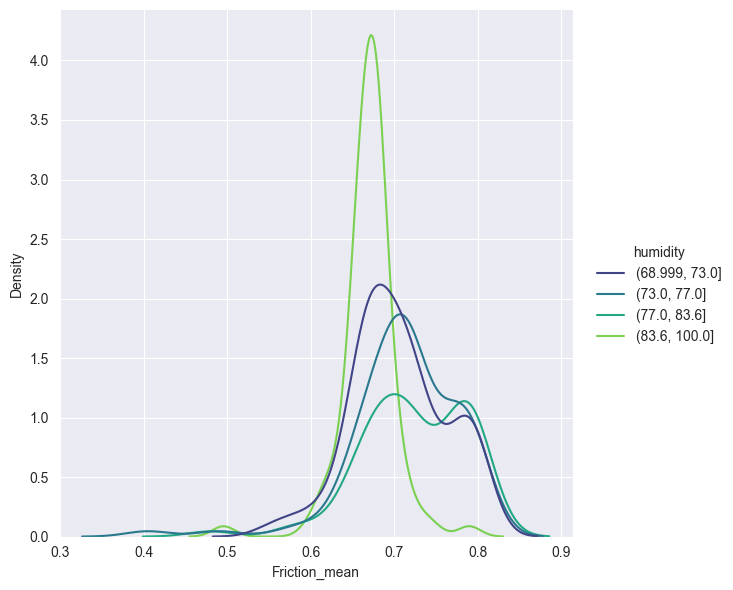

In [16]:
sns.displot(
    x=samplel4["Friction_mean"], hue=pd.qcut(samplel4['humidity'], q = [0.2, 0.4, 0.6, 0.8, 1]),
    kind="kde", height=6,
    palette="viridis",
)

Условные распределения Friction при условии Water: здесь дискретизация по квантилям (для того, чтобы подвыборки были не самые малые в каждой группе)

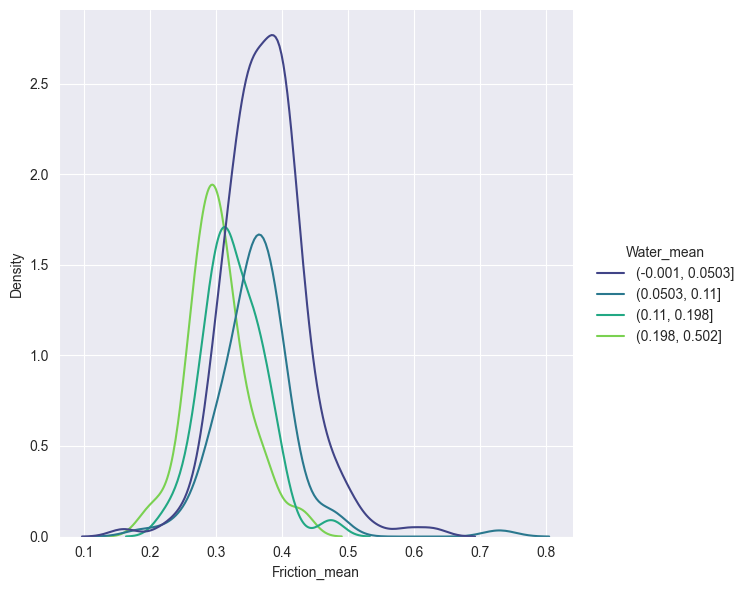

In [17]:
sns.displot(
    x=sampleb4["Friction_mean"], hue=pd.qcut(sampleb4['Water_mean'], q = [0.2, 0.4, 0.6, 0.8, 1]),
    kind="kde", height=6,
    palette="viridis",
)

In [18]:
samplel4.describe()

State_  Friction_mean     Ta_mean  Tsurf_mean  Water_mean  \
count  413.000000     413.000000  413.000000  413.000000  413.000000   
mean     2.232446       0.702652    7.521634   -1.397904    0.210166   
std      0.772220       0.062209    4.919456    4.483932    0.300220   
min      1.000000       0.380000   -6.300000  -12.900000    0.000000   
25%      2.000000       0.670000    4.000000   -4.602000    0.027000   
50%      2.000000       0.700000    8.500000    0.300000    0.092500   
75%      3.000000       0.735556   10.800000    1.940476    0.264000   
max      3.000000       0.810000   16.482143    5.492857    1.998750   

       Speed_mean  Height_mean  Direction_min  Direction_max    maxtempC  ...  \
count  413.000000   413.000000     413.000000     413.000000  413.000000  ...   
mean    33.798909    64.505240     138.938257     204.491041   -2.789346  ...   
std     26.127387    38.597830     105.350367     105.432269    4.500990  ...   
min      0.220000     9.000000       0.000000       1.800000  -14.000000  ...   
25%     10.109091    41.000000      47.700000     111.800000   -6.000000  ...   
50%     27.400000    55.120000     112.200000     224.200000   -2.000000  ...   
75%     60.350000    73.090909     226.900000     289.600000    1.000000  ...   
max     82.400000   287.000000     357.000000     359.800000    6.000000  ...   

       WindChillC  WindGustKmph  cloudcover    humidity    precipMM  \
count  413.000000     413.00000  413.000000  413.000000  413.000000   
mean    -8.268765      21.96368   60.382567   76.496368    0.144794   
std      6.267726       8.27302   31.835040   10.371877    0.390610   
min    -25.000000       4.00000    3.000000   46.000000    0.000000   
25%    -12.000000      16.00000   35.000000   70.000000    0.000000   
50%     -7.000000      21.00000   62.000000   76.000000    0.000000   
75%     -3.000000      28.00000   91.000000   81.000000    0.000000   
max      3.000000      51.00000  100.000000  100.000000    2.800000   

          pressure       tempC  visibility  winddirDegree  windspeedKmph  
count   413.000000  413.000000  413.000000     413.000000     413.000000  
mean   1008.067797   -3.569007    8.777240     144.600484      13.368039  
std       7.674839    4.764677    2.473896      46.072628       4.651458  
min     991.000000  -15.000000    1.000000      89.000000       3.000000  
25%    1002.000000   -7.000000   10.000000     107.000000      11.000000  
50%    1007.000000   -2.000000   10.000000     141.000000      13.000000  
75%    1013.000000    1.000000   10.000000     157.000000      15.000000  
max    1030.000000    6.000000   10.000000     307.000000      26.000000  

[8 rows x 27 columns]

Корреляционная матрица по выборке с $State < 4$

In [19]:
samplel4.drop(columns=['State_']).corr()

Friction_mean   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
Friction_mean       1.000000 -0.355478   -0.401647   -0.401350    0.136358   
Ta_mean            -0.355478  1.000000    0.913878    0.371971   -0.130991   
Tsurf_mean         -0.401647  0.913878    1.000000    0.403017   -0.084051   
Water_mean         -0.401350  0.371971    0.403017    1.000000   -0.227352   
Speed_mean          0.136358 -0.130991   -0.084051   -0.227352    1.000000   
Height_mean        -0.088557  0.145013    0.120611    0.247534   -0.133616   
Direction_min      -0.030183 -0.009989   -0.029319    0.000357    0.171766   
Direction_max      -0.032567 -0.013642    0.011122    0.007302   -0.126646   
maxtempC           -0.454560  0.637569    0.763082    0.510977   -0.031538   
mintempC           -0.387187  0.442241    0.562094    0.476730    0.009100   
totalSnow_cm       -0.165505  0.147593    0.225916    0.279541   -0.180365   
sunHour             0.060131 -0.390988   -0.386108    0.050000    0.023127   
uvIndex             0.207294 -0.309704   -0.331296   -0.338711    0.054023   
DewPointC          -0.441443  0.661606    0.771736    0.571439   -0.113381   
FeelsLikeC         -0.431004  0.560286    0.670289    0.467797   -0.039095   
HeatIndexC         -0.448369  0.632751    0.739250    0.489517   -0.057956   
WindChillC         -0.431004  0.560286    0.670289    0.467797   -0.039095   
WindGustKmph        0.140348  0.026068   -0.049291   -0.217573    0.014767   
cloudcover         -0.301111  0.403499    0.452720    0.465931   -0.197437   
humidity           -0.165868  0.327808    0.379720    0.438761   -0.179561   
precipMM           -0.213260  0.218225    0.279519    0.454164   -0.177372   
pressure            0.120389 -0.390287   -0.395768   -0.132192   -0.071016   
tempC              -0.448849  0.631163    0.738099    0.491028   -0.054867   
visibility          0.256108 -0.298093   -0.374669   -0.474606    0.266461   
winddirDegree      -0.315752  0.378842    0.444307    0.532116   -0.255496   
windspeedKmph       0.133148  0.005133   -0.043206   -0.124014   -0.083373   

               Height_mean  Direction_min  Direction_max  maxtempC  mintempC  \
Friction_mean    -0.088557      -0.030183      -0.032567 -0.454560 -0.387187   
Ta_mean           0.145013      -0.009989      -0.013642  0.637569  0.442241   
Tsurf_mean        0.120611      -0.029319       0.011122  0.763082  0.562094   
Water_mean        0.247534       0.000357       0.007302  0.510977  0.476730   
Speed_mean       -0.133616       0.171766      -0.126646 -0.031538  0.009100   
Height_mean       1.000000      -0.024681      -0.054036  0.187892  0.139631   
Direction_min    -0.024681       1.000000       0.509475 -0.034123 -0.042225   
Direction_max    -0.054036       0.509475       1.000000 -0.001575 -0.030929   
maxtempC          0.187892      -0.034123      -0.001575  1.000000  0.866600   
mintempC          0.139631      -0.042225      -0.030929  0.866600  1.000000   
totalSnow_cm     -0.026517      -0.052045       0.025743  0.225463  0.191366   
sunHour           0.009263       0.009630      -0.000585 -0.208495 -0.103633   
uvIndex          -0.070157       0.086908       0.037675 -0.308734 -0.368146   
DewPointC         0.210528      -0.039151      -0.018490  0.931914  0.836745   
FeelsLikeC        0.161603      -0.031117      -0.017822  0.952117  0.863740   
HeatIndexC        0.177468      -0.039478      -0.014991  0.975797  0.865181   
WindChillC        0.161603      -0.031117      -0.017822  0.952117  0.863740   
WindGustKmph     -0.019888      -0.031372      -0.009959 -0.389911 -0.491086   
cloudcover        0.121332      -0.120781      -0.088030  0.541943  0.456720   
humidity          0.159560      -0.008012      -0.016000  0.249397  0.246682   
precipMM          0.102467      -0.019248      -0.028606  0.322224  0.329454   
pressure         -0.083559       0.083312       0.009690 -0.248864 -0.147419   
tempC             0.176421      -0.037292      -0.011840  0.975310  

Значимость корреляции:
Пусть $\hat{\rho}_n$ --- оценка $\rho = \rho(\xi, \eta)$ по выборке, $(\xi, \eta)^T \sim N(\mu, \Sigma)$.
Проверяем гипотезу $H_0: \rho = 0$.
Статистика: $$ t = \sqrt{n-2}\frac{\hat{\rho}_n}{\sqrt{1-\hat{\rho}^2_n}} \sim t(n-2) $$
если же данные не нормальны, то пользуемся предельными критическими значениями ст. норм. распределения.
После $z$-преобразования:
$$ z = \frac{1}{2} \ln \frac{1+\hat\rho_n}{1-\hat\rho_n},\ z_0 = \frac{1}{2} \ln \frac{1+\rho_0}{1-\rho_0} $$
его можно привести к виду:
$$ \sqrt{n-3}(z-z_0) \to^d N(0, 1) $$

Результаты применения критерия проверки значимости корреляции Friction с остальными признаками для этой группы наблюдений. Здесь слева направо даны коэффициент корреляции, левая и правая границы доверительного интервала для коэф. корреляции и p-value; гипотеза проверялась на уровне значимости $\alpha = 0.05$. При нормально распределённых данных статистика этого теста имеет точное распределение --- р. Стьюдента с $n-3$ степенями свободы, иначе мы рассматриваем асипмтотический тест с предельным стандартным нормальным распределением. (доказательство этого http://personal.psu.edu/drh20/asymp/fall2002/lectures/ln08.pdf)

Выделим признаки, которые значимо коррелируют с Friction

In [20]:
corr_res_l4 = corr_significance.multiple_corr_test(samplel4, pivot = 'Friction_mean',
                                     regressors=samplel4.columns.difference(['Friction_mean', 'State_']))
corr_res_l4

$\rho$      left     right       p-value
DewPointC     -0.441443 -0.570817 -0.377226  3.989176e-21
Direction_max -0.032567 -0.129375  0.064217  5.092437e-01
Direction_min -0.030183 -0.126988  0.066604  5.407569e-01
FeelsLikeC    -0.431004 -0.557924 -0.364333  4.120532e-20
HeatIndexC    -0.448369 -0.579453 -0.385861  8.100522e-22
Height_mean   -0.088557 -0.185585  0.008007  7.221487e-02
Speed_mean     0.136358  0.040417  0.234009  5.508267e-03
Ta_mean       -0.355478 -0.468496 -0.274904  9.557084e-14
Tsurf_mean    -0.401647 -0.522407 -0.328815  1.925895e-17
Water_mean    -0.401350 -0.522053 -0.328461  2.043193e-17
WindChillC    -0.431004 -0.557924 -0.364333  4.120532e-20
WindGustKmph   0.140348  0.044485  0.238077  4.266880e-03
cloudcover    -0.301111 -0.407537 -0.213946  4.202592e-10
humidity      -0.165868 -0.264210 -0.070619  7.141603e-04
maxtempC      -0.454560 -0.587229 -0.393638  1.888100e-22
mintempC      -0.387187 -0.505283 -0.311691  3.204025e-16
precipMM      -0.213260 -0.313380 -0.119788  1.235629e-05
pressure       0.120389  0.024180  0.217772  1.436138e-02
sunHour        0.060131 -0.036592  0.156999  2.226903e-01
tempC         -0.448849 -0.580054 -0.386463  7.242582e-22
totalSnow_cm  -0.165505 -0.263837 -0.070246  7.339269e-04
uvIndex        0.207294  0.113547  0.307138  2.174664e-05
visibility     0.256108  0.165143  0.358734  1.311608e-07
winddirDegree -0.315752 -0.423717 -0.230125  5.164871e-11
windspeedKmph  0.133148  0.037148  0.230739  6.733028e-03

Попробуем построить первую линейную модель по этим признакам

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.api import qqplot
from scipy.stats import shapiro

In [43]:
def linear_regression_report(data, target: str, features: list, model):
    lm = model.fit(data[features], data[target])
    r2 = r2_score(y_true=data[target], y_pred=lm.predict(data[features]))
    mse = mean_squared_error(y_true=data[target], y_pred=lm.predict(data[features]))
    residuals = data[target] - lm.predict(data[features])

    m = residuals.mean()
    std = residuals.std()

    sns.histplot(x = residuals)
    plt.title("Residuals distribution")
    plt.xlabel("Residuals")
    qqplot((residuals-m)/std, line='45')

    shapiro_results = shapiro(residuals)
    return {'model': model,
            'r2_score': r2,
            'mse': mse,
            'residuals': residuals,
            'shapiro': shapiro_results}

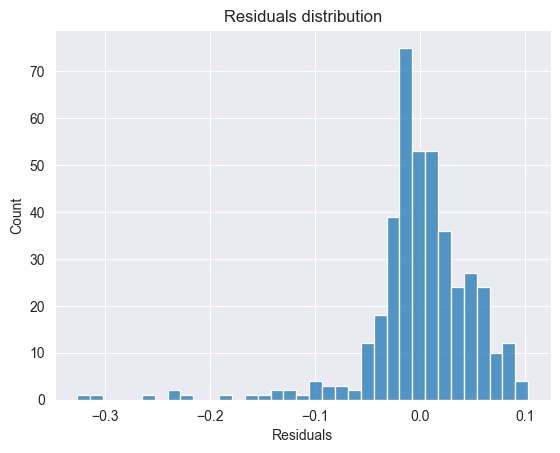

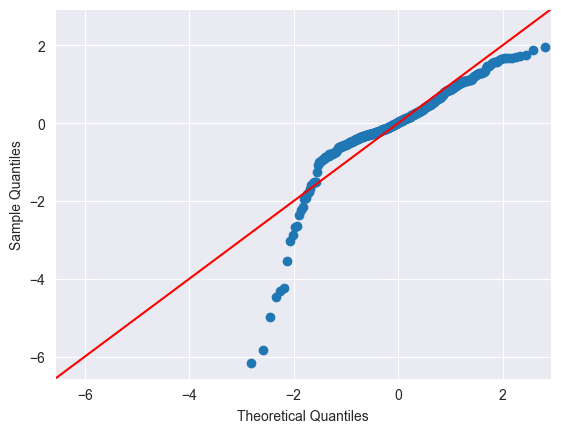

In [24]:
res1 = linear_regression_report(data = samplel4, target='Friction_mean',
                                features=corr_res_l4.index.values, model=LinearRegression())

R2-score и MSE у неё соответственно. Выглядит невпечатляюще + распределение остатков отнюдь не нормальное.

In [25]:
res1['r2_score'], res1['mse']

(0.2750800042451257, 0.0027986375829764406)

Критерий Шапиро-Уилка отвергает нормальность остатков

In [26]:
res1['shapiro']

ShapiroResult(statistic=0.8366694450378418, pvalue=3.192880005950607e-20)

Отберём признаки по корреляциям с другими и частной корреляции с целевым

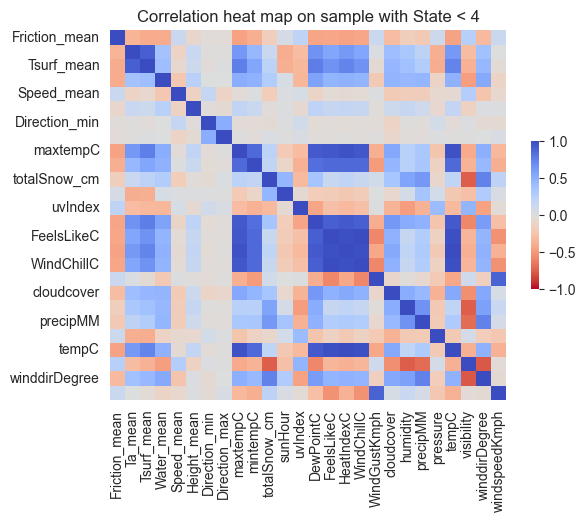

In [27]:
sns.heatmap(samplel4.drop(columns=['State_']).corr(),
            cmap = "coolwarm_r",
            cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
            vmin=-1, vmax=1, center=0, annot_kws={"fontsize":8})
plt.title("Correlation heat map on sample with State < 4")
sns.set(font_scale=0.7)

Как видно, целая группа температурных признаков коррелируют друг с другом. Для дальнейшего из них выберем только Tsurf_mean. Также уберём признак WindGustKmph, так как он сильно коррелирует с признаком windspeedKmph, а ещё признак visibility дискретен (принимает значения от 1 до 10).

Частная корреляция (partial correlation)
$$ \rho(\xi, \eta \mid \alpha_1, \dots, \alpha_n) = \rho(\xi - \widetilde{\xi}, \eta - \widetilde{\eta}) $$
$$ \widetilde{\xi} = \arg \min_{\xi^* \in K} \mathbf{E} (\xi - \xi^*)^2 $$
$$ \widetilde{\eta} = \arg \min_{\eta^* \in K} \mathbf{E} (\eta - \eta^*)^2 $$
$$ K = \{a_0 + a_1 \alpha_1 + \dots + a_n \alpha_n\} $$

In [28]:
partial_corr.par_corr(samplel4.drop(columns=['State_']))

Friction_mean   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
Friction_mean       1.000000  0.016092   -0.070497   -0.180341    0.101975   
Ta_mean             0.016092  1.000000    0.759075    0.070027   -0.129728   
Tsurf_mean         -0.070497  0.759075    1.000000   -0.057219    0.068646   
Water_mean         -0.180341  0.070027   -0.057219    1.000000   -0.118134   
Speed_mean          0.101975 -0.129728    0.068646   -0.118134    1.000000   
Height_mean         0.023450  0.077178   -0.125738    0.156642   -0.143486   
Direction_min      -0.066715  0.123073   -0.091588    0.037000    0.305813   
Direction_max       0.008129 -0.108015    0.079934   -0.009037   -0.280150   
maxtempC           -0.040309 -0.210655    0.259055    0.143086    0.155146   
mintempC           -0.010199 -0.019292   -0.081602    0.024623    0.057120   
totalSnow_cm       -0.033256 -0.128788    0.080726   -0.139885    0.031513   
sunHour            -0.024808  0.013207   -0.222358    0.087721    0.129816   
uvIndex             0.048452  0.011179    0.062491   -0.062072   -0.062770   
DewPointC           0.029884  0.034842   -0.018399   -0.010030   -0.037550   
FeelsLikeC          0.001626  0.002097   -0.002141   -0.000129    0.004246   
HeatIndexC         -0.005023  0.031880    0.013722   -0.034995   -0.051762   
WindChillC          0.000377 -0.000045    0.000100   -0.000445   -0.004662   
WindGustKmph       -0.063127  0.130132    0.074474   -0.061688    0.125886   
cloudcover         -0.051907 -0.004581   -0.176467    0.086402   -0.054293   
humidity           -0.006042 -0.019267    0.095653    0.049623    0.072094   
precipMM           -0.014741 -0.071569   -0.015623    0.072191   -0.008590   
pressure           -0.028223 -0.071675   -0.129705    0.094267   -0.096161   
tempC              -0.005081 -0.009297   -0.015681    0.082176    0.044099   
visibility         -0.019256  0.009326   -0.020518    0.041637    0.142997   
winddirDegree       0.021175  0.115393    0.010048    0.175504   -0.129765   
windspeedKmph       0.055074 -0.056729   -0.006422   -0.064418   -0.095254   

               Height_mean  Direction_min  Direction_max  maxtempC  mintempC  \
Friction_mean     0.023450      -0.066715       0.008129 -0.040309 -0.010199   
Ta_mean           0.077178       0.123073      -0.108015 -0.210655 -0.019292   
Tsurf_mean       -0.125738      -0.091588       0.079934  0.259055 -0.081602   
Water_mean        0.156642       0.037000      -0.009037  0.143086  0.024623   
Speed_mean       -0.143486       0.305813      -0.280150  0.155146  0.057120   
Height_mean       1.000000       0.012426      -0.066431  0.044879 -0.071931   
Direction_min     0.012426       1.000000       0.554738 -0.034622 -0.023153   
Direction_max    -0.066431       0.554738       1.000000  0.074119 -0.039740   
maxtempC          0.044879      -0.034622       0.074119  1.000000  0.321593   
mintempC         -0.071931      -0.023153      -0.039740  0.321593  1.000000   
totalSnow_cm     -0.135327      -0.058723       0.019468 -0.144375  0.015798   
sunHour           0.141499      -0.003822       0.011475  0.033619  0.076576   
uvIndex           0.060217       0.074747      -0.016842  0.329531 -0.287433   
DewPointC         0.000841      -0.006341       0.001347  0.000717 -0.025784   
FeelsLikeC       -0.000441       0.000004       0.001160 -0.001628  0.002417   
HeatIndexC       -0.004476       0.013102      -0.093085  0.047429  0.017692   
WindChillC       -0.002962       0.000601       0.000461 -0.001735 -0.005570   
WindGustKmph      0.074962       0.016025      -0.105934  0.204014 -0.254729   
cloudcover       -0.107729      -0.032700      -0.110627 -0.074803 -0.040206   
humidity          0.070430       0.018041      -0.008265  0.045220  0.052626   
precipMM         -0.017883       0.059629      -0.085665 -0.204623  0.113468   
pressure         -0.080240       0.057395      -0.081175 -0.229069  0.149485   
tempC            -0.022448       0.018571       0.081115 -0.000625  

Взглянув на матрицу частных корреляций, мы видим, что с целевым признаком нет выделяющихся связей

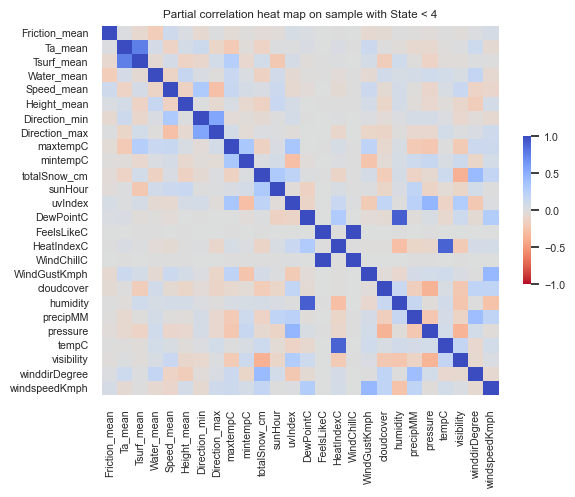

In [29]:
sns.heatmap(partial_corr.par_corr(samplel4.drop(columns=['State_'])),
            cmap = "coolwarm_r",
            cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
            vmin=-1, vmax=1, center=0, annot_kws={"fontsize":8})
plt.title("Partial correlation heat map on sample with State < 4")
sns.set(font_scale=0.7)

Набор отобранных признаков:

In [30]:
set_for_model2 = ['Tsurf_mean',
       'Water_mean', 'Speed_mean', 'Height_mean',
       'Direction_min', 'Direction_max', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'DewPointC', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'winddirDegree', 'windspeedKmph']

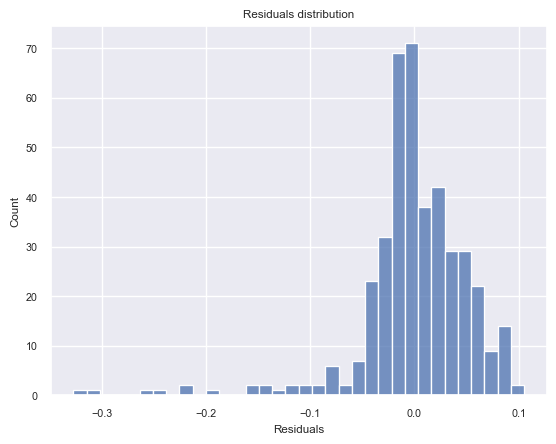

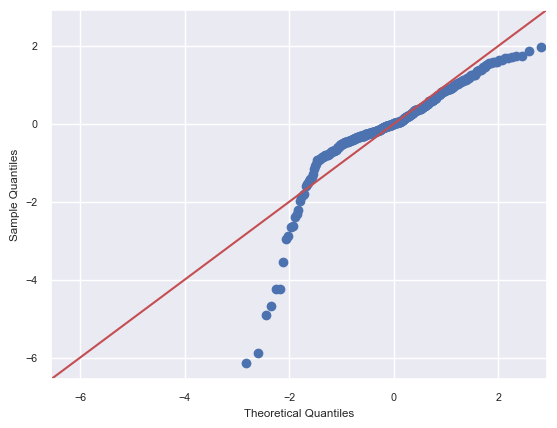

In [31]:
res2 = linear_regression_report(data = samplel4, target='Friction_mean',
                                features=set_for_model2, model=LinearRegression())

In [32]:
res2['r2_score'], res2['mse']

(0.26745475742624414, 0.002828075731257302)

In [33]:
res2['shapiro']

ShapiroResult(statistic=0.835412859916687, pvalue=2.696399901506458e-20)

Отбор признаков не решил проблему полностью. Попробуем доотобрать признаки с помощью регуляризации Lasso.

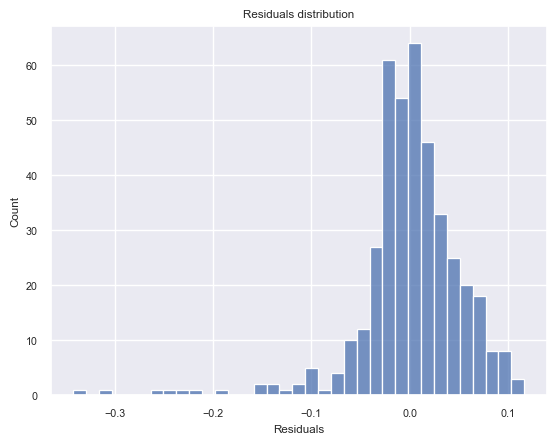

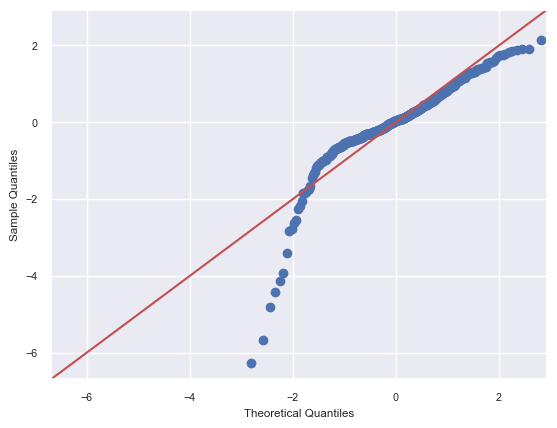

In [36]:
from sklearn.linear_model import Lasso
res3 = linear_regression_report(data = samplel4, target='Friction_mean',
                                features=set_for_model2, model=Lasso(alpha=0.01))

Признаки, которые Lasso отбросил:

In [37]:
mask = np.abs(res3['model'].coef_) < 0.0001
samplel4[set_for_model2].columns[mask]

Index(['Water_mean', 'Height_mean', 'Direction_min', 'Direction_max',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'precipMM', 'pressure'],
      dtype='object')

... и те, что были оставлены:

In [38]:
samplel4[set_for_model2].columns[~mask]

Index(['Tsurf_mean', 'Speed_mean', 'DewPointC', 'cloudcover', 'humidity',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [39]:
res3['shapiro']

ShapiroResult(statistic=0.8581743240356445, pvalue=6.769774863116807e-19)

Но качество модели всё ещё плохое. Последнее, что стоит рассмотреть --- это анализ аутлаеров. В первую очередь были отброшены некоторые из наблюдений, у которых Friction < 0.5 (они выделяются в Pair plot'e ниже.

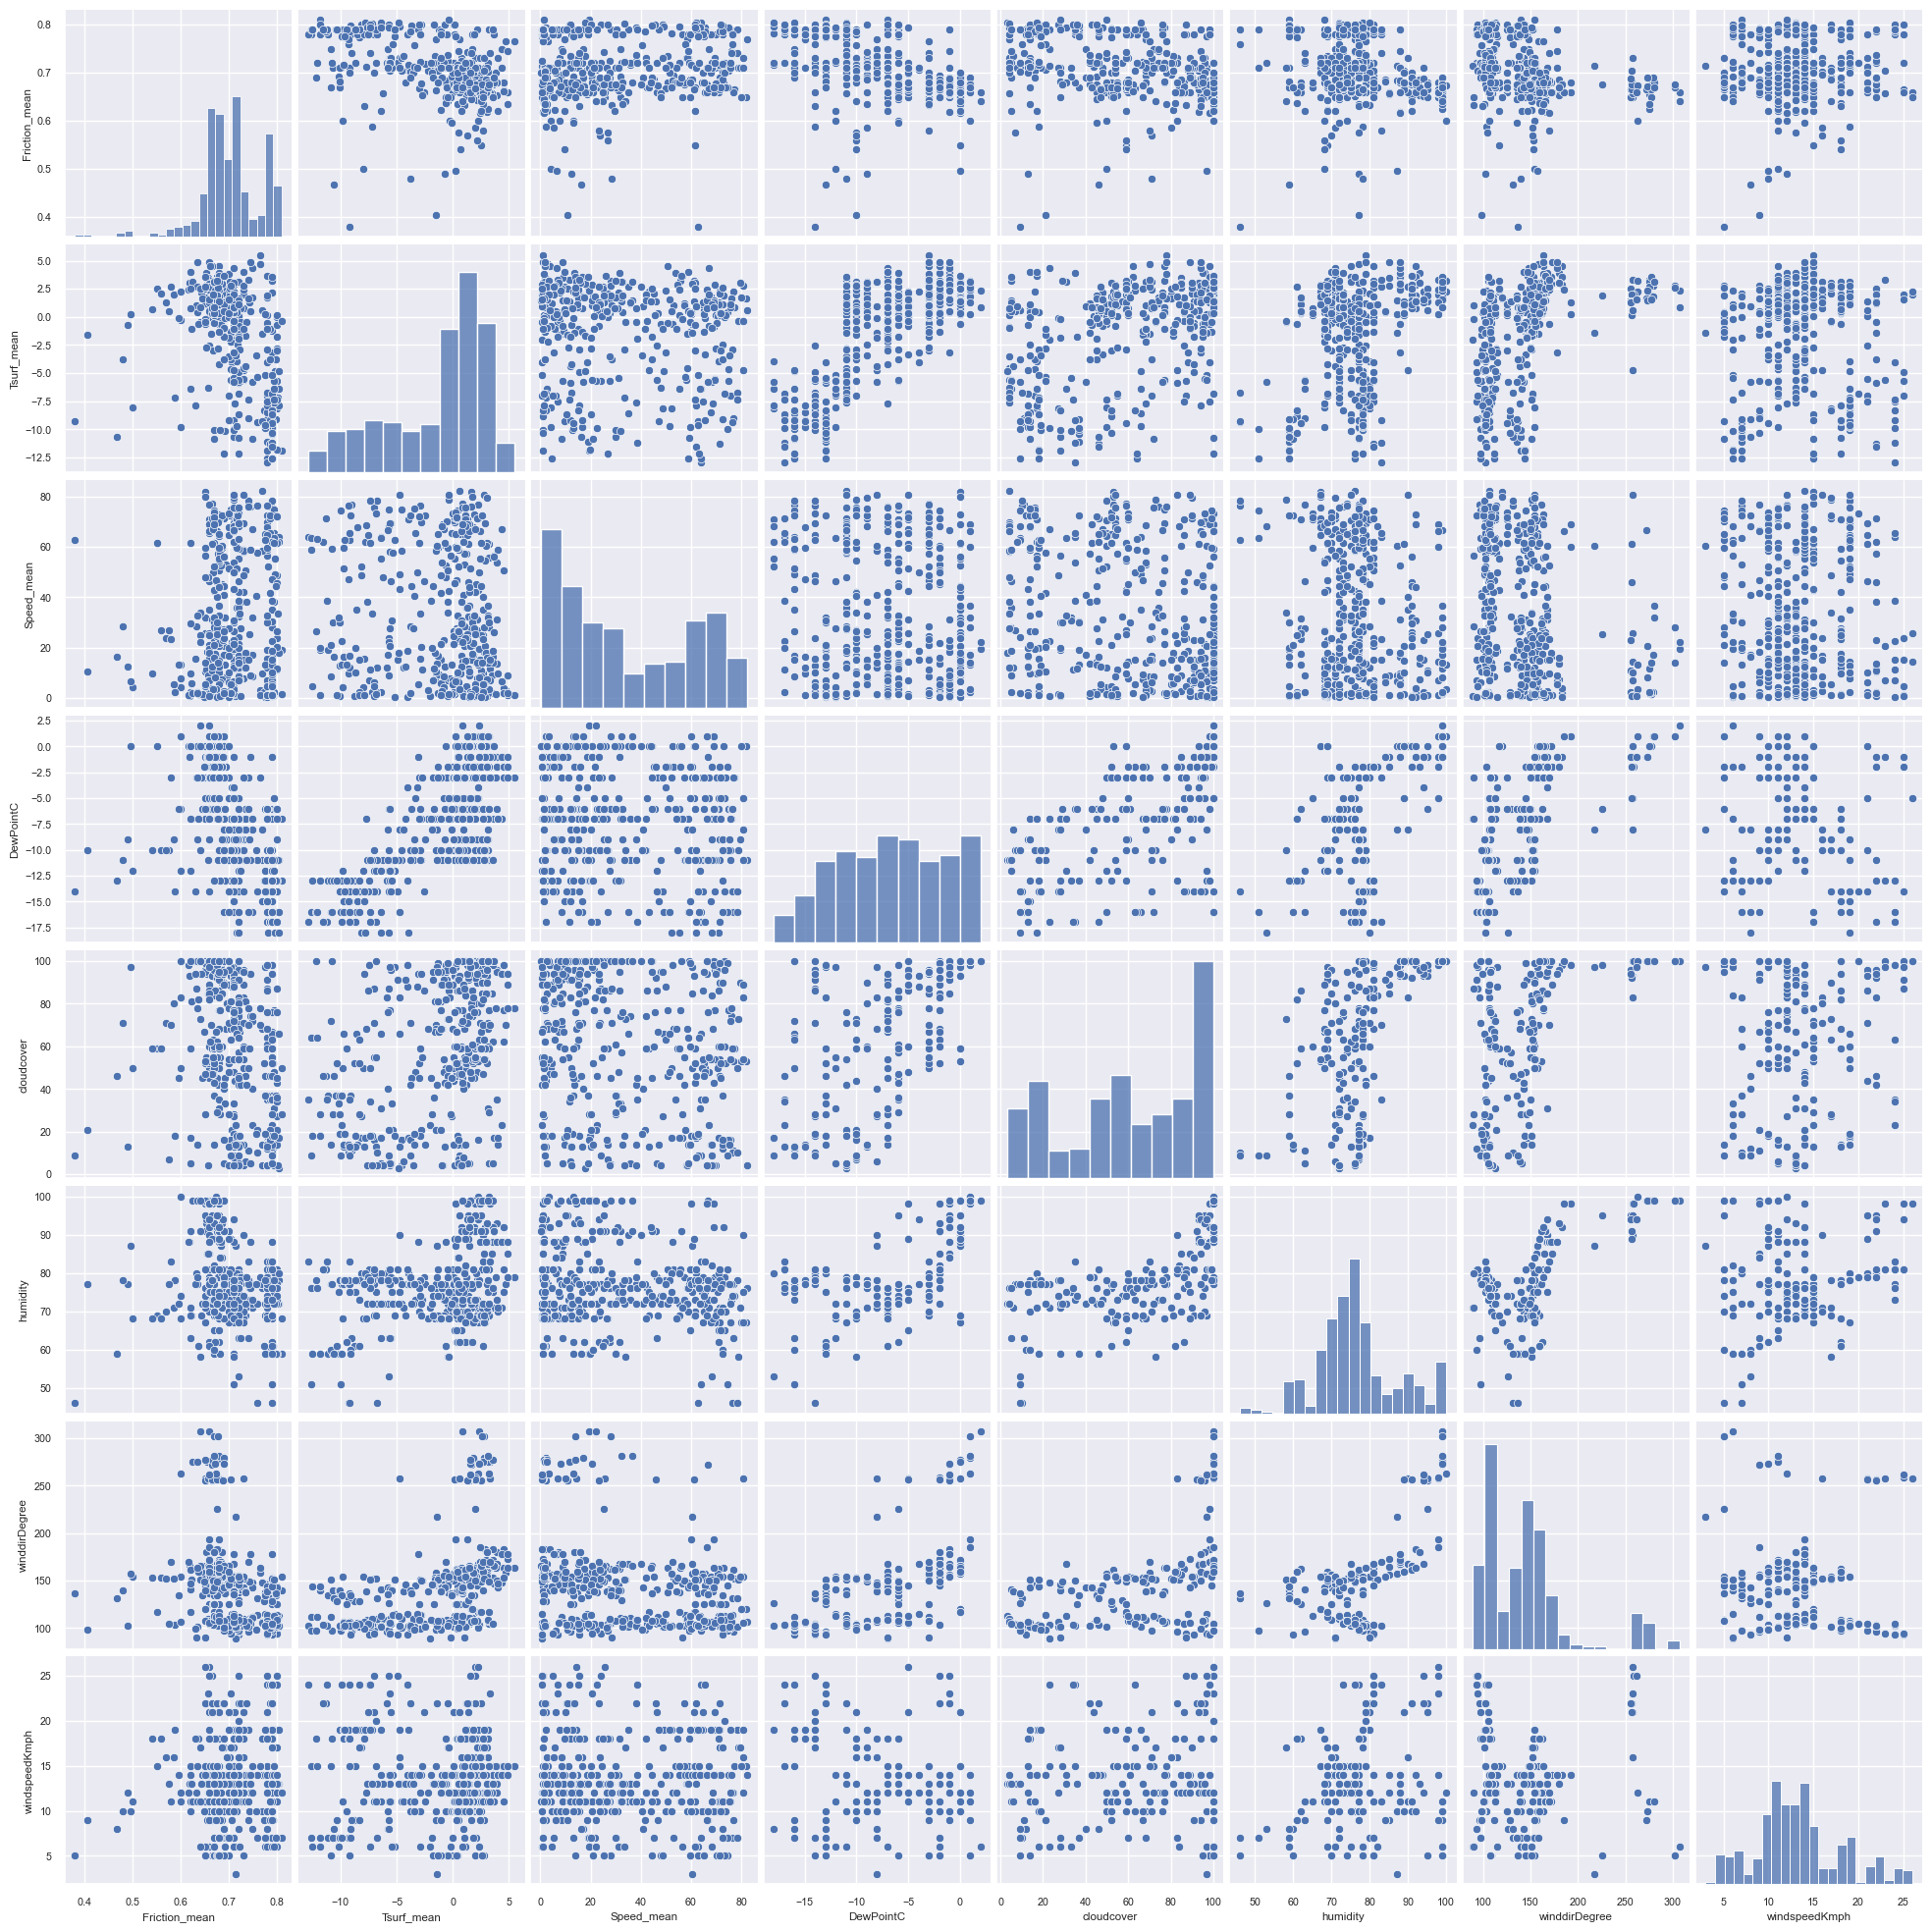

In [40]:
sns.pairplot(data = samplel4[['Friction_mean'] + ['Tsurf_mean', 'Speed_mean', 'DewPointC', 'cloudcover', 'humidity',
       'winddirDegree', 'windspeedKmph']])

Попробуем построить модель по полученным данным.

In [41]:
samplel4_nooutliers = samplel4[samplel4['Friction_mean'] > 0.5]

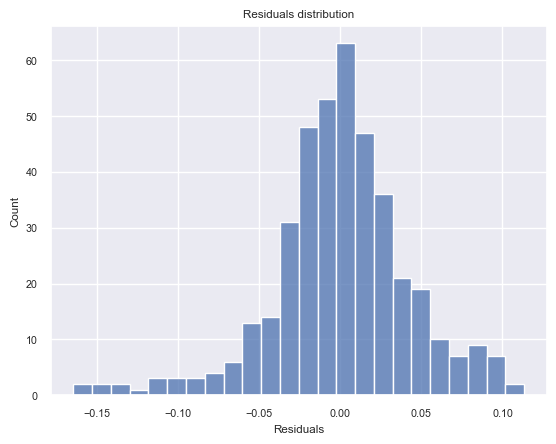

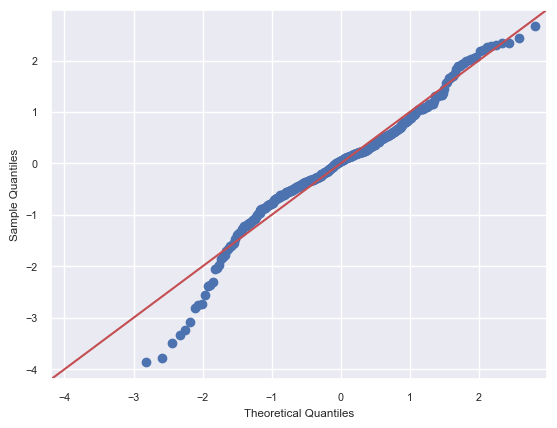

In [44]:
set_for_model4 = ['Tsurf_mean', 'Speed_mean', 'DewPointC', 'cloudcover', 'humidity',
       'winddirDegree', 'windspeedKmph']

res4 = linear_regression_report(data = samplel4_nooutliers, target='Friction_mean',
                                features=set_for_model4, model=LinearRegression())

Качество улучшилось:

In [45]:
res4['r2_score'], res4['mse']

(0.36698432396827074, 0.0018089764013459622)

Всё ещё нельзя сказать, что остатки нормальны, но мы близки к чему-то такому.

In [46]:
res4['shapiro']

ShapiroResult(statistic=0.9631732702255249, pvalue=1.4519318192185438e-08)

Последним остаётся рассмотреть и отбросить аутлаеры по отношению к расстоянию Кука. Расстояние Кука измеряет удалённость отдельной точки данных по отношению к регрессии. Если оно велико для конкретной точки данных, то она оказывает значимое влияние на обучение линейной модели (большой рычаг).

In [47]:
from yellowbrick.regressor import CooksDistance

1      0.001448
3      0.012427
8      0.002723
10     0.007562
12     0.011036
         ...   
981    0.000190
988    0.003357
991    0.000317
996    0.000934
997    0.000623
Length: 406, dtype: float64

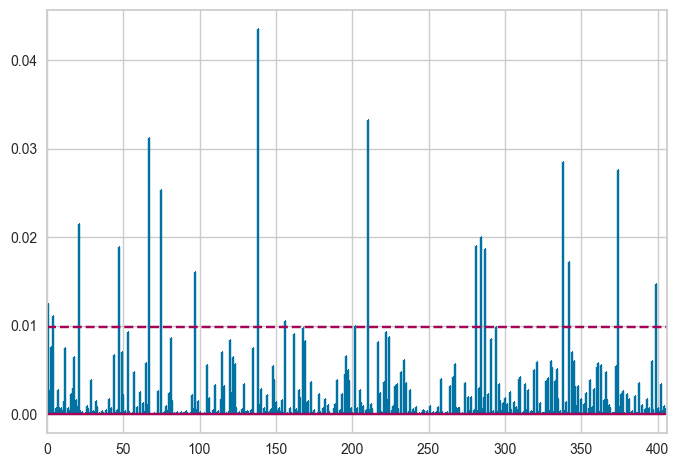

In [48]:
cookdist = CooksDistance().fit(samplel4_nooutliers[set_for_model4], samplel4_nooutliers['Friction_mean'])
cookdist.distance_

Отбросим наблюдения, для которых это расстояние выше 0.01.

In [49]:
samplel4_nooutliers2 = samplel4_nooutliers[cookdist.distance_ < 0.01]

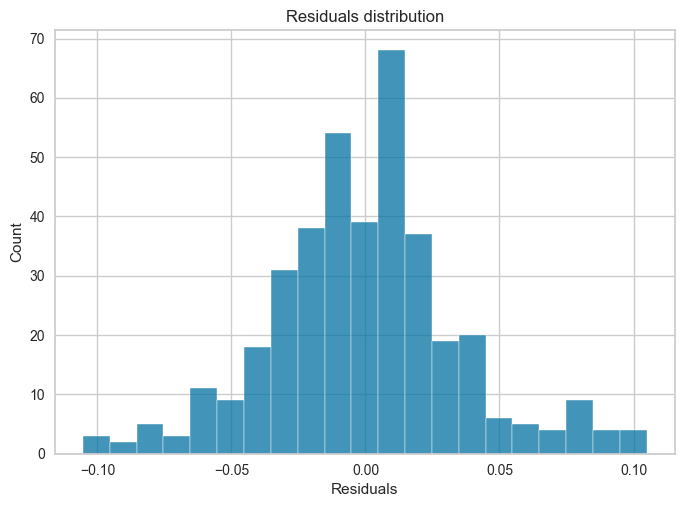

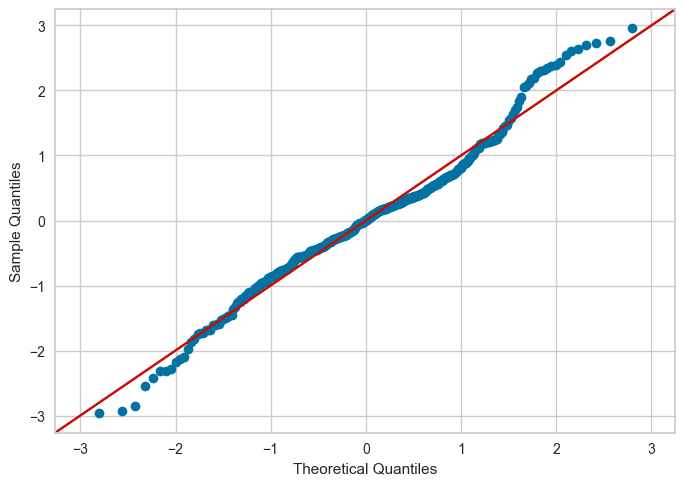

In [50]:
res5 = linear_regression_report(data = samplel4_nooutliers2, target='Friction_mean',
                                features=set_for_model4, model=LinearRegression())

In [51]:
res5['r2_score'], res5['mse']

(0.49294134061194206, 0.0012573668169905837)

In [52]:
res5['shapiro']

ShapiroResult(statistic=0.9813315868377686, pvalue=6.390195630956441e-05)

Качество полученной модели заметно лучше предыдущих. Эту модель можно доработать до валидной (например, посмотреть расстояния Махаланобиса для выделения других аутлаеров, которые визуально определить по Pair plot трудно.

Наверное, ещё нужно проинтерпретировать полученную модель (в плане того, что монотонность связей логична).

Всё аналогичное для остальных групп наблюдений можно повторить.

In [87]:
sampleb4.drop(columns=['State_']).corr()

Friction_mean   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
Friction_mean       1.000000 -0.100352   -0.086914   -0.451652    0.091095   
Ta_mean            -0.100352  1.000000    0.898587    0.250599   -0.097054   
Tsurf_mean         -0.086914  0.898587    1.000000    0.257587   -0.085390   
Water_mean         -0.451652  0.250599    0.257587    1.000000   -0.021767   
Speed_mean          0.091095 -0.097054   -0.085390   -0.021767    1.000000   
Height_mean         0.049485 -0.014091    0.004865   -0.102640   -0.165386   
Direction_min       0.039691 -0.019264   -0.037919    0.017412    0.181426   
Direction_max       0.037324  0.017784    0.029977   -0.045683   -0.288355   
maxtempC           -0.057208  0.378489    0.462523    0.178682   -0.092759   
mintempC           -0.079677  0.362513    0.368999    0.167369   -0.048979   
totalSnow_cm        0.135255  0.278031    0.295043   -0.151023    0.071620   
sunHour             0.122094 -0.552126   -0.564100   -0.282225    0.164519   
uvIndex            -0.159051 -0.220106   -0.281566    0.082054    0.043536   
DewPointC          -0.047407  0.502041    0.577089    0.164087   -0.109947   
FeelsLikeC         -0.092556  0.392323    0.457448    0.198136   -0.109716   
HeatIndexC         -0.069699  0.408418    0.455246    0.205596   -0.120834   
WindChillC         -0.092556  0.392323    0.457448    0.198136   -0.109716   
WindGustKmph        0.136610 -0.120188   -0.200092   -0.059582    0.031770   
cloudcover          0.092276  0.259549    0.293563   -0.115928    0.077630   
humidity            0.037623  0.337599    0.420350   -0.041722    0.000374   
precipMM            0.065077  0.235505    0.267314   -0.027908    0.058561   
pressure            0.041066  0.171302    0.211718   -0.108983    0.024143   
tempC              -0.071196  0.401090    0.448737    0.204108   -0.116004   
visibility         -0.110033 -0.249865   -0.310102    0.120170   -0.078931   
winddirDegree       0.000491  0.394549    0.469950   -0.015904   -0.029684   
windspeedKmph       0.114646 -0.073566   -0.146439   -0.032449    0.032968   

               Height_mean  Direction_min  Direction_max  maxtempC  mintempC  \
Friction_mean     0.049485       0.039691       0.037324 -0.057208 -0.079677   
Ta_mean          -0.014091      -0.019264       0.017784  0.378489  0.362513   
Tsurf_mean        0.004865      -0.037919       0.029977  0.462523  0.368999   
Water_mean       -0.102640       0.017412      -0.045683  0.178682  0.167369   
Speed_mean       -0.165386       0.181426      -0.288355 -0.092759 -0.048979   
Height_mean       1.000000      -0.129900      -0.011884  0.102335  0.154557   
Direction_min    -0.129900       1.000000       0.280310 -0.064998 -0.019078   
Direction_max    -0.011884       0.280310       1.000000 -0.015770 -0.058570   
maxtempC          0.102335      -0.064998      -0.015770  1.000000  0.716557   
mintempC          0.154557      -0.019078      -0.058570  0.716557  1.000000   
totalSnow_cm     -0.120377       0.037087       0.047832  0.131185  0.058949   
sunHour           0.042222       0.028751      -0.045208 -0.280842 -0.331455   
uvIndex          -0.094528       0.032621      -0.046884 -0.215376 -0.203624   
DewPointC         0.088385      -0.032935       0.049121  0.864844  0.708418   
FeelsLikeC        0.121491      -0.066659      -0.001378  0.895744  0.760711   
HeatIndexC        0.090981      -0.043983      -0.003740  0.949598  0.786197   
WindChillC        0.121491      -0.066659      -0.001378  0.895744  0.760711   
WindGustKmph     -0.121341       0.069130      -0.056947  0.019310 -0.074762   
cloudcover       -0.042496      -0.036859       0.039524  0.190509  0.201300   
humidity          0.014832      -0.008901       0.122977  0.120904  0.089694   
precipMM          0.025518      -0.044461      -0.002844  0.268454  0.136959   
pressure         -0.135889       0.059897       0.100824  0.004149  0.013179   
tempC             0.087897      -0.044521      -0.005840  0.946776  

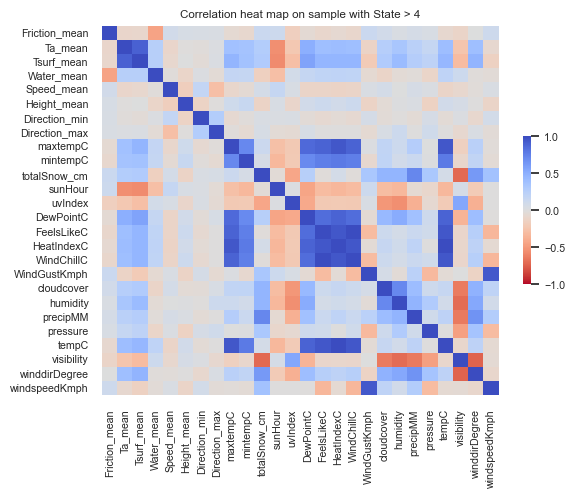

In [84]:
sns.heatmap(sampleb4.drop(columns=['State_']).corr(),
            cmap = "coolwarm_r",
            cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
            vmin=-1, vmax=1, center=0, annot_kws={"fontsize":8})
plt.title("Correlation heat map on sample with State > 4")
sns.set(font_scale=0.7)

In [89]:
sign_featsl4 = corr_res_l4[corr_res_l4['p-value'] < 0.05]
sign_featsl4

$\rho$      left     right       p-value
DewPointC     -0.441443 -0.570817 -0.377226  3.989176e-21
FeelsLikeC    -0.431004 -0.557924 -0.364333  4.120532e-20
HeatIndexC    -0.448369 -0.579453 -0.385861  8.100522e-22
Speed_mean     0.136358  0.040417  0.234009  5.508267e-03
Ta_mean       -0.355478 -0.468496 -0.274904  9.557084e-14
Tsurf_mean    -0.401647 -0.522407 -0.328815  1.925895e-17
Water_mean    -0.401350 -0.522053 -0.328461  2.043193e-17
WindChillC    -0.431004 -0.557924 -0.364333  4.120532e-20
WindGustKmph   0.140348  0.044485  0.238077  4.266880e-03
cloudcover    -0.301111 -0.407537 -0.213946  4.202592e-10
humidity      -0.165868 -0.264210 -0.070619  7.141603e-04
maxtempC      -0.454560 -0.587229 -0.393638  1.888100e-22
mintempC      -0.387187 -0.505283 -0.311691  3.204025e-16
precipMM      -0.213260 -0.313380 -0.119788  1.235629e-05
pressure       0.120389  0.024180  0.217772  1.436138e-02
tempC         -0.448849 -0.580054 -0.386463  7.242582e-22
totalSnow_cm  -0.165505 -0.263837 -0.070246  7.339269e-04
uvIndex        0.207294  0.113547  0.307138  2.174664e-05
visibility     0.256108  0.165143  0.358734  1.311608e-07
winddirDegree -0.315752 -0.423717 -0.230125  5.164871e-11
windspeedKmph  0.133148  0.037148  0.230739  6.733028e-03

In [22]:
corr_res_b4 = corr_significance.multiple_corr_test(sampleb4, pivot = 'Friction_mean',
                                     regressors=['Tsurf_mean', 'Water_mean', 'Speed_mean', 'Height_mean', 'mintempC', 'DewPointC', 'humidity', 'pressure'])
corr_res_b4

$\rho$      left     right       p-value
Tsurf_mean  -0.086914 -0.178123  0.003855  6.055355e-02
Water_mean  -0.451652 -0.577762 -0.395784  7.469167e-25
Speed_mean   0.091095  0.000359  0.182337  4.913729e-02
Height_mean  0.049485 -0.041463  0.140515  2.858935e-01
mintempC    -0.079677 -0.170835  0.011143  8.544007e-02
DewPointC   -0.047407 -0.138432  0.043547  3.066383e-01
humidity     0.037623 -0.053348  0.128630  4.172799e-01
pressure     0.041066 -0.049900  0.132078  3.759240e-01

In [86]:
partial_corr.par_corr(sampleb4.drop(columns=['State_']))

Friction_mean   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
Friction_mean       1.000000 -0.071063    0.087293   -0.416229    0.117661   
Ta_mean            -0.071063  1.000000    0.824827    0.002957   -0.031657   
Tsurf_mean          0.087293  0.824827    1.000000    0.100131    0.055213   
Water_mean         -0.416229  0.002957    0.100131    1.000000    0.065588   
Speed_mean          0.117661 -0.031657    0.055213    0.065588    1.000000   
Height_mean         0.052073  0.028938   -0.023186   -0.128086   -0.153732   
Direction_min       0.010354  0.000603    0.000911    0.034924    0.274346   
Direction_max       0.051388 -0.007553   -0.009630   -0.009846   -0.365069   
maxtempC           -0.075284 -0.339627    0.383591   -0.000421    0.039453   
mintempC           -0.061461  0.088917   -0.074163   -0.023996    0.080473   
totalSnow_cm       -0.053784  0.013347    0.121147   -0.151400    0.062345   
sunHour            -0.068181 -0.099147   -0.141869   -0.150267    0.168790   
uvIndex            -0.148720  0.057738   -0.102610   -0.054996    0.157287   
DewPointC           0.004215  0.107428   -0.057827   -0.019784   -0.085847   
FeelsLikeC          0.001758  0.003037    0.003132   -0.002819    0.003069   
HeatIndexC          0.038096  0.078174    0.002166    0.003881   -0.052406   
WindChillC         -0.001825 -0.001877    0.002446   -0.004481    0.004744   
WindGustKmph        0.084343  0.208730   -0.203344   -0.061531   -0.039276   
cloudcover          0.011138  0.140602   -0.166317   -0.187225    0.091999   
humidity           -0.036689 -0.142876    0.119005    0.005506    0.093035   
precipMM            0.033584  0.078161   -0.148438    0.055228    0.080578   
pressure            0.052282  0.024281   -0.035859   -0.085783   -0.048039   
tempC              -0.041543 -0.084409    0.007287   -0.025337    0.055802   
visibility         -0.047451 -0.064819    0.114800   -0.086593   -0.029416   
winddirDegree      -0.042107 -0.079941    0.213180   -0.019299   -0.163308   
windspeedKmph      -0.014798 -0.158098    0.065681    0.125742    0.033220   

               Height_mean  Direction_min  Direction_max  maxtempC  mintempC  \
Friction_mean     0.052073       0.010354       0.051388 -0.075284 -0.061461   
Ta_mean           0.028938       0.000603      -0.007553 -0.339627  0.088917   
Tsurf_mean       -0.023186       0.000911      -0.009630  0.383591 -0.074163   
Water_mean       -0.128086       0.034924      -0.009846 -0.000421 -0.023996   
Speed_mean       -0.153732       0.274346      -0.365069  0.039453  0.080473   
Height_mean       1.000000      -0.054043      -0.026955  0.129566  0.170593   
Direction_min    -0.054043       1.000000       0.356924 -0.075698  0.048880   
Direction_max    -0.026955       0.356924       1.000000  0.016289 -0.076304   
maxtempC          0.129566      -0.075698       0.016289  1.000000 -0.066447   
mintempC          0.170593       0.048880      -0.076304 -0.066447  1.000000   
totalSnow_cm     -0.065815       0.019757       0.065281 -0.053272  0.008362   
sunHour           0.071818       0.004874       0.028182  0.047964 -0.066751   
uvIndex          -0.045571      -0.013483       0.055165  0.136056 -0.056420   
DewPointC        -0.044619       0.116974      -0.080869  0.200614 -0.054481   
FeelsLikeC       -0.003021       0.007249       0.001594  0.001552 -0.017646   
HeatIndexC       -0.005280      -0.027911       0.053575  0.130428  0.093555   
WindChillC        0.001333       0.004741      -0.003394  0.004896 -0.015148   
WindGustKmph     -0.114917       0.026410      -0.066997  0.398805 -0.155964   
cloudcover       -0.129734      -0.026267      -0.013026  0.235876  0.026275   
humidity          0.077080      -0.106509       0.106028 -0.217182  0.018517   
precipMM          0.088627      -0.031984      -0.023613  0.150185 -0.096421   
pressure         -0.129167       0.059355      -0.018550  0.024274  0.019366   
tempC            -0.021849      -0.003610      -0.020406 -0.075726 -

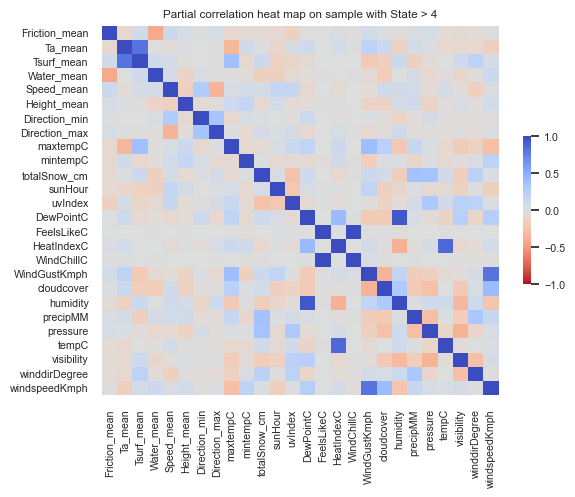

In [85]:
sns.heatmap(partial_corr.par_corr(sampleb4.drop(columns=['State_'])),
            cmap = "coolwarm_r",
            cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
            vmin=-1, vmax=1, center=0, annot_kws={"fontsize":8})
plt.title("Partial correlation heat map on sample with State > 4")
sns.set(font_scale=0.7)

In [25]:
corr_res_b4[corr_res_b4['p-value'] < 0.05]

$\rho$      left     right       p-value
Water_mean -0.451652 -0.577762 -0.395784  7.469167e-25
Speed_mean  0.091095  0.000359  0.182337  4.913729e-02

In [91]:
from statsmodels.nonparametric import kernel_regression

In [92]:
def conditional_exp_var(data, regressor, target):
    nwe = kernel_regression.KernelReg(endog=data[target], exog  = data[regressor], var_type='c')
    nwe_variance = kernel_regression.KernelReg(endog=(data[target] - nwe.fit()[0])**2, exog  = data[regressor], var_type='c')
    x = np.linspace(start=data[regressor].min(), stop = data[regressor].max(), num=1000)

    plt.subplots(nrows=2, ncols=1, tight_layout = True)
    plt.subplot(2, 1, 1)
    sns.scatterplot(data = data, x = regressor, y = target, hue = 'State_')
    sns.lineplot(x = x, y = nwe.fit(x)[0])

    plt.subplot(2, 1 ,2)
    sns.lineplot(x = x, y = nwe_variance.fit(x)[0])
    plt.xlabel(regressor)
    plt.ylabel('$\mathbf{D}$('+target+' | ' +regressor + ')')

Conditional expectation and variance:
If $\mathbf{E}(\xi \mid \eta)$ is a regression of $\xi$ on $\eta$, then $\mathbf{D}(\xi \mid \eta) = \mathbf{E}((\xi - \mathbf{E}(\xi \mid \eta))^2 \mid \eta)$ is a regression of $(\xi - \mathbf{E}(\xi \mid \eta))^2$ on $\eta$.

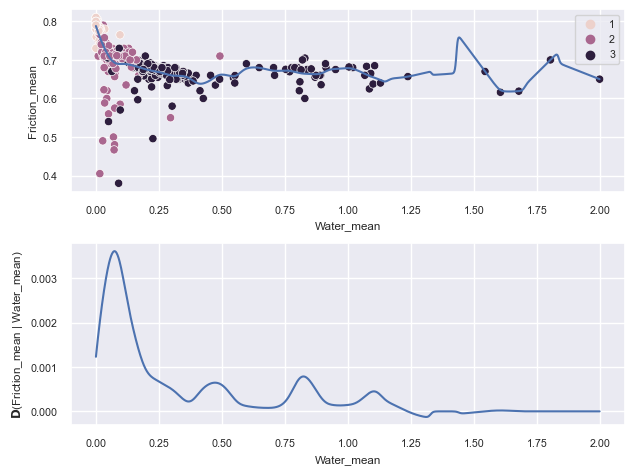

In [93]:
conditional_exp_var(samplel4, 'Water_mean', 'Friction_mean')

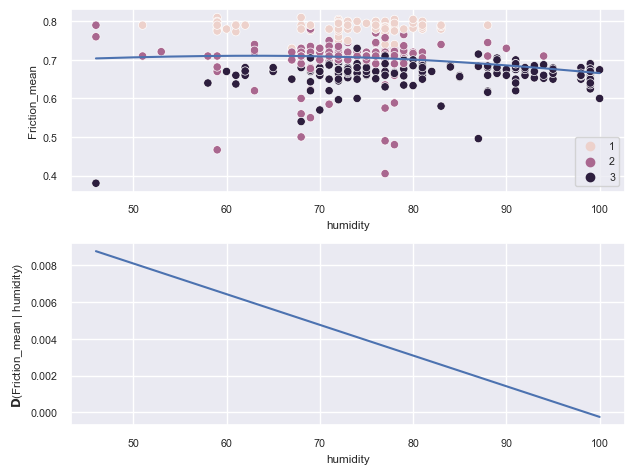

In [94]:
conditional_exp_var(samplel4, 'humidity', 'Friction_mean')

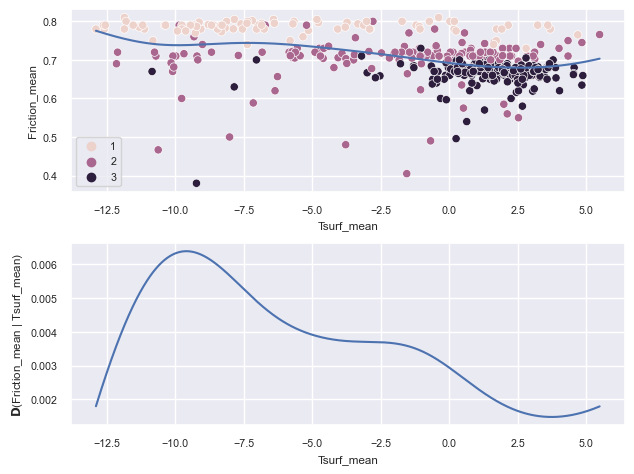

In [95]:
conditional_exp_var(samplel4, 'Tsurf_mean', 'Friction_mean')